In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import math
import re
import plotly.express as px
import statsmodels.api as sm

from sqlalchemy import create_engine
import psycopg2

In [38]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

train.sort_values(['date','city'],inplace=True)
test.sort_values(['date','city'],inplace=True)

train['date_day'] = train['date'].dt.day_of_year
train['date_month'] = train['date'].dt.month

test['date_day'] = test['date'].dt.day_of_year
test['date_month'] = test['date'].dt.month

x = train[['date_day','pm2_5']].groupby('date_day').aggregate('mean')


In [39]:
city_list = train['city'].unique()
country_list =  train['country'].unique()
print(city_list)
print(country_list)


['Kampala' 'Nairobi' 'Lagos' 'Bujumbura']
['Uganda' 'Kenya' 'Nigeria' 'Burundi']


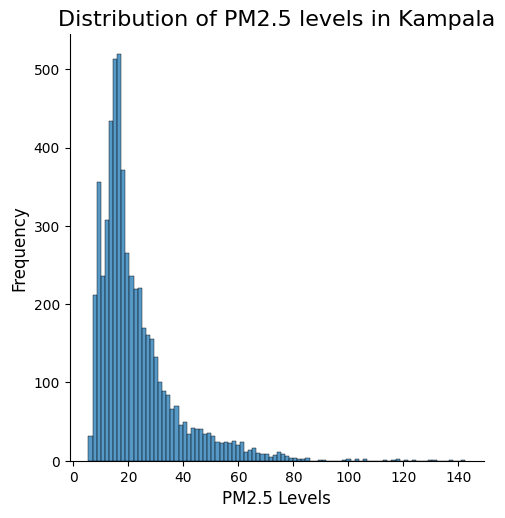

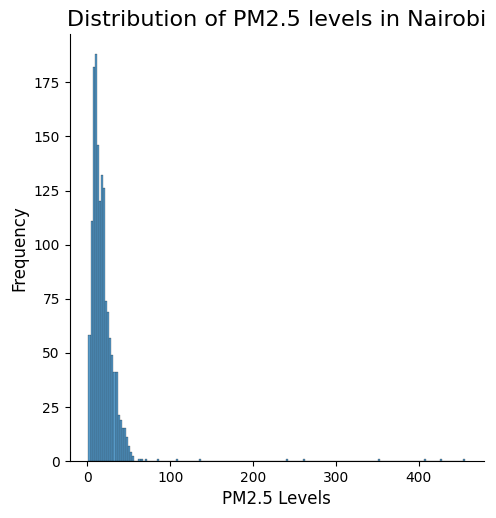

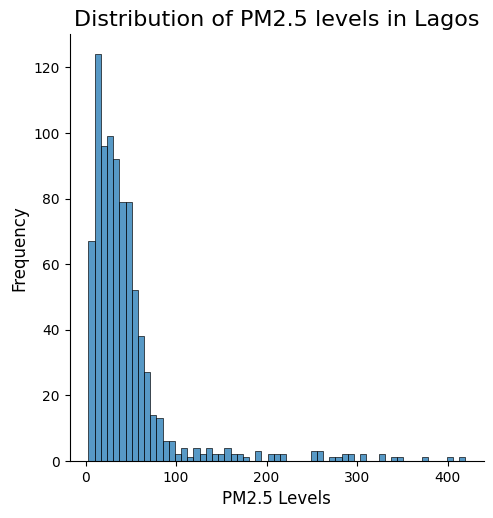

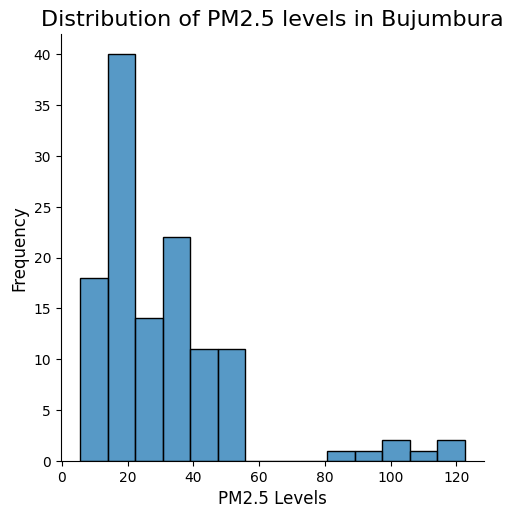

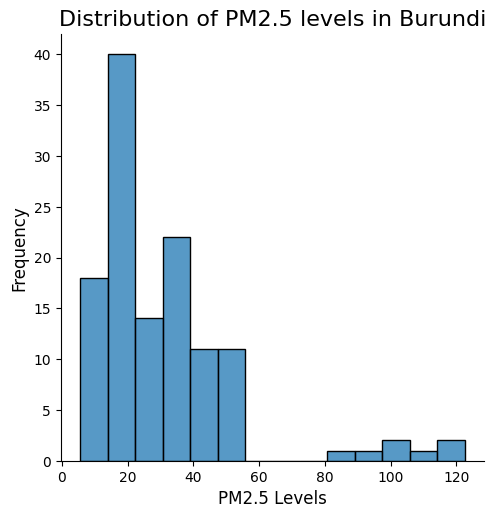

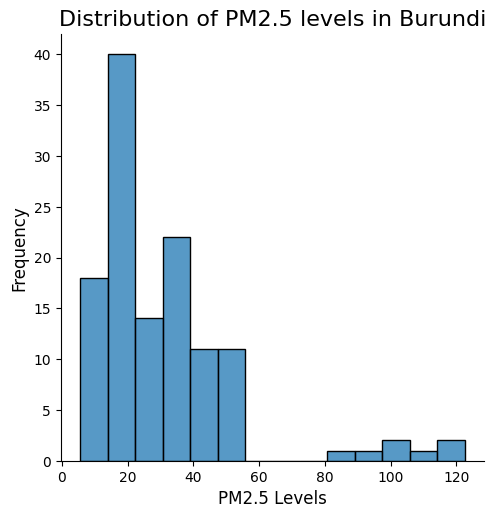

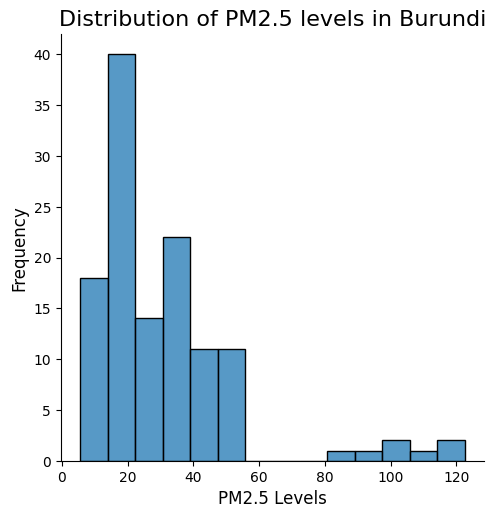

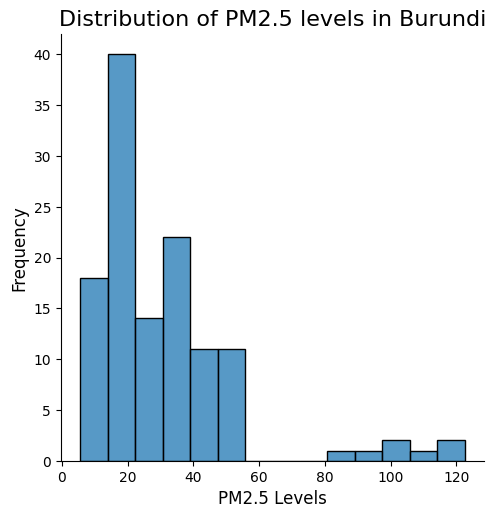

In [40]:
train[train['city']==city_list[0]]['pm2_5']
for i in range(0,len(city_list)):
    sns.displot(train[train['city']==city_list[i]]['pm2_5'])
    plt.title(f'Distribution of PM2.5 levels in {city_list[i]}', fontsize=16)
    plt.xlabel('PM2.5 Levels', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
for j in range(0,len(country_list)):
     sns.displot(train[train['city']==city_list[i]]['pm2_5'])
     plt.title(f'Distribution of PM2.5 levels in {country_list[i]}', fontsize=16)
     plt.xlabel('PM2.5 Levels', fontsize=12)
     plt.ylabel('Frequency', fontsize=12)

<Axes: xlabel='date_day', ylabel='pm2_5'>

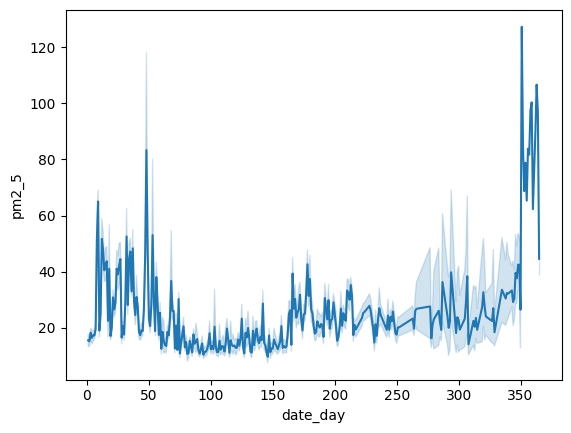

In [26]:
sns.lineplot(y=train['pm2_5'],x=train['date_day'])

<Axes: xlabel='date_day', ylabel='pm2_5'>

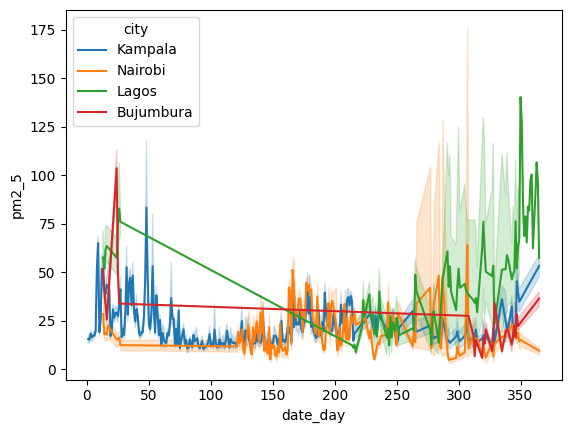

In [41]:
sns.lineplot(y=train['pm2_5'],x=train['date_day'],hue=train['city'])

<Axes: xlabel='date_day', ylabel='pm2_5'>

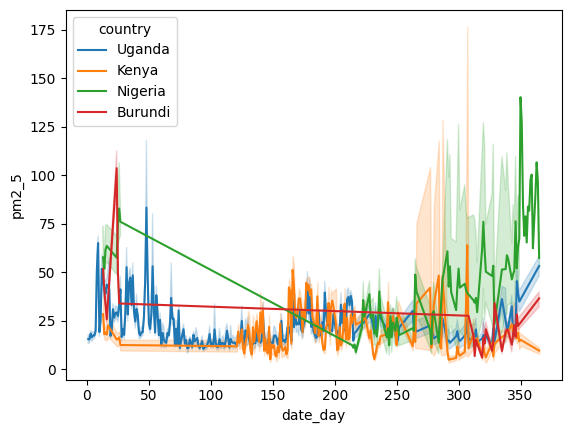

In [42]:
sns.lineplot(y=train['pm2_5'],x=train['date_day'],hue=train['country'])

<Axes: xlabel='date', ylabel='pm2_5'>

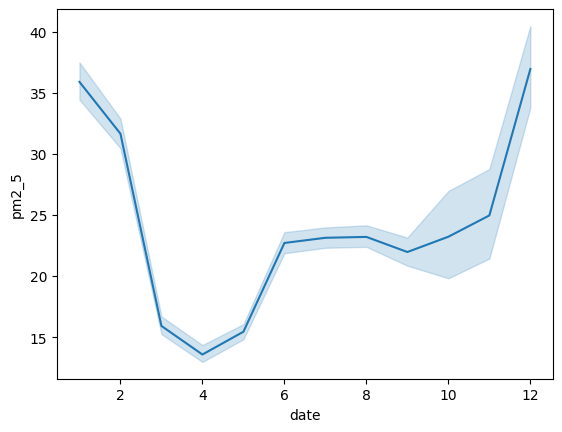

In [29]:
sns.lineplot(x=train['date'].dt.month,y=train['pm2_5'])

<Axes: xlabel='date', ylabel='pm2_5'>

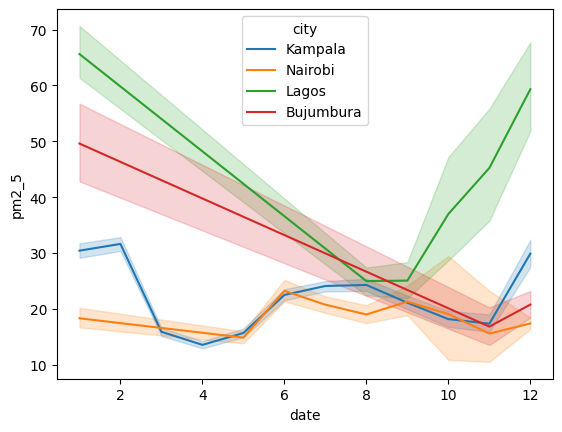

In [30]:
sns.lineplot(x=train['date'].dt.month,y=train['pm2_5'],hue=train['city'])

<Axes: xlabel='hour', ylabel='pm2_5'>

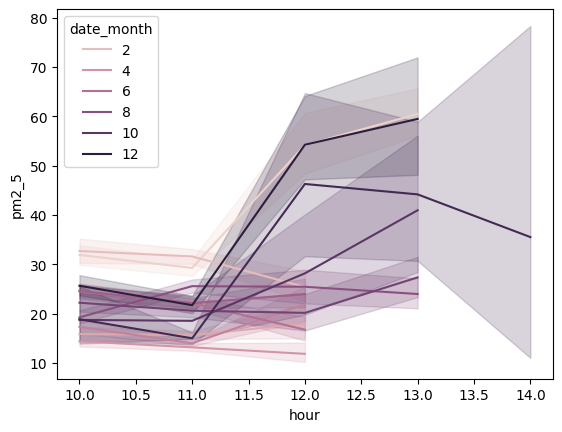

In [31]:
sns.lineplot(x=train['hour'],y=train['pm2_5'],hue=train['date_month'])

<Axes: xlabel='date', ylabel='pm2_5'>

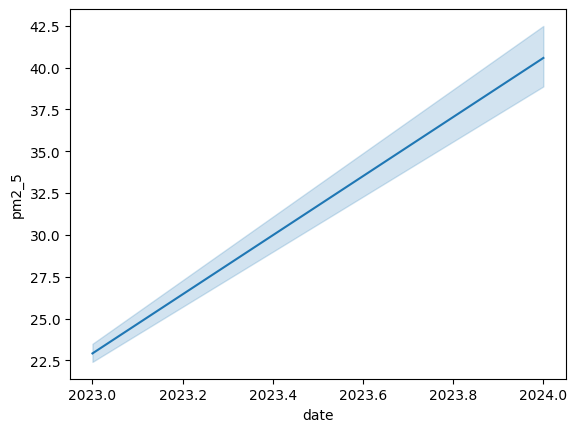

In [35]:
sns.lineplot(x=train['date'].dt.year,y=train['pm2_5'])

<Axes: xlabel='site_latitude', ylabel='site_longitude'>

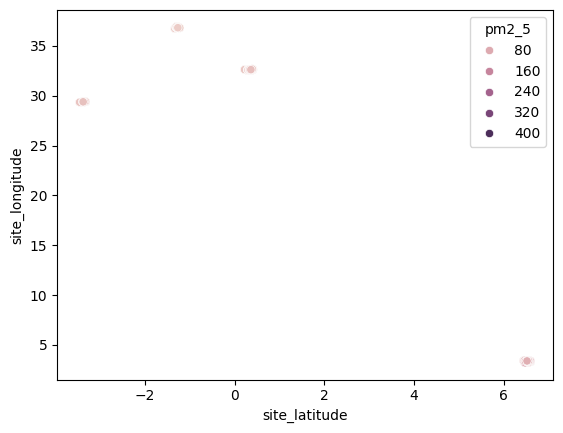

In [36]:
sns.scatterplot(x=train['site_latitude'],y=train['site_longitude'],hue=train['pm2_5'])

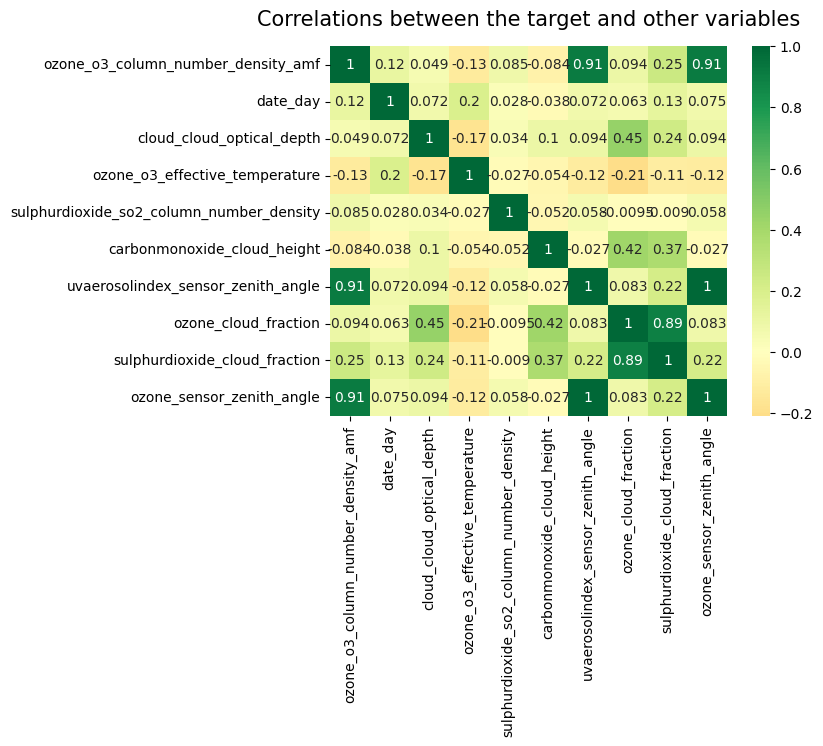

In [43]:
traintest = pd.concat([train,test])
# Select only numerical features
train_num_df = train.select_dtypes(include=['number'])
top10_corrs = abs(train_num_df.corr()['pm2_5']).sort_values(ascending = False).tail(10)
# top10_corrs += top10_corrs + train['pm2_5']
corr = train_num_df[list(top10_corrs.index)].corr()
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlations between the target and other variables', pad = 15, fontdict={'size': 15})
plt.show()

<Axes: >

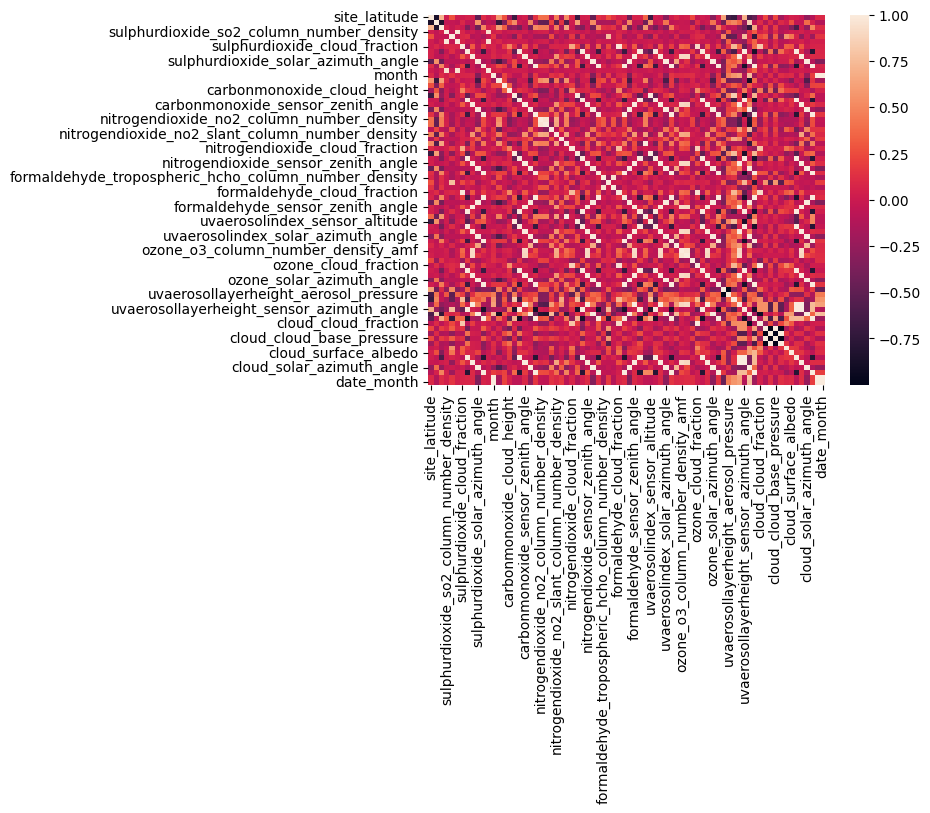

In [44]:
sns.heatmap(test.select_dtypes(include='number').corr(),linewidths=0.0028105)


city
Bujumbura    Axes(0.125,0.11;0.775x0.77)
Kampala      Axes(0.125,0.11;0.775x0.77)
Lagos        Axes(0.125,0.11;0.775x0.77)
Nairobi      Axes(0.125,0.11;0.775x0.77)
Name: sulphurdioxide_so2_column_number_density, dtype: object

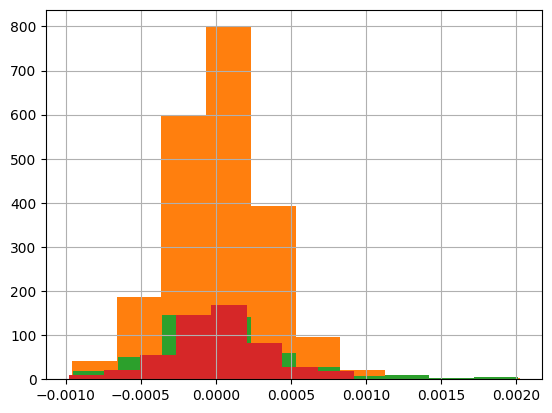

In [45]:
train.groupby('city')['sulphurdioxide_so2_column_number_density'].hist()

city
Accra      Axes(0.125,0.11;0.775x0.77)
Gulu       Axes(0.125,0.11;0.775x0.77)
Kisumu     Axes(0.125,0.11;0.775x0.77)
Yaoundé    Axes(0.125,0.11;0.775x0.77)
Name: sulphurdioxide_so2_column_number_density, dtype: object

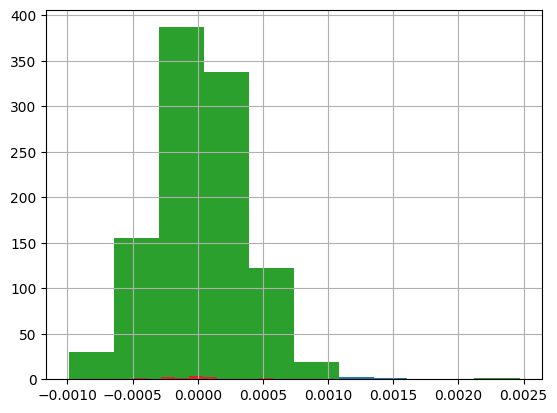

In [46]:
test.groupby('city')['sulphurdioxide_so2_column_number_density'].hist()

<Axes: xlabel='cloud_cloud_base_pressure', ylabel='pm2_5'>

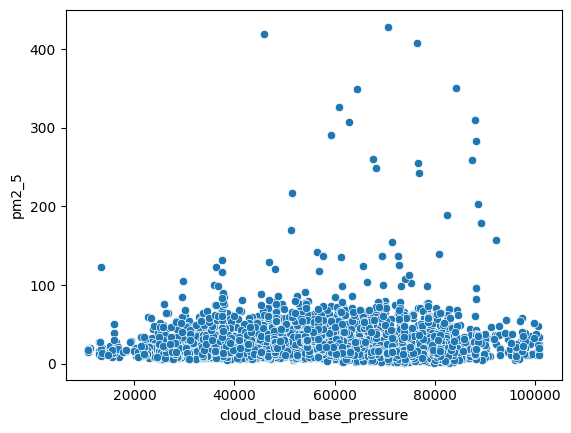

In [47]:
sns.scatterplot(x=train['cloud_cloud_base_pressure'],y=train['pm2_5'])

<Axes: xlabel='sulphurdioxide_so2_column_number_density', ylabel='pm2_5'>

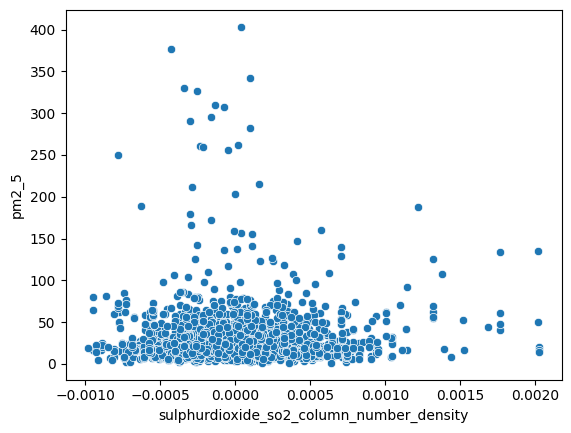

In [48]:
sns.scatterplot(x=train['sulphurdioxide_so2_column_number_density'],y=train['pm2_5'])

In [49]:
train[['pm2_5','nitrogendioxide_no2_slant_column_number_density']].corr()

,pm2_5,nitrogendioxide_no2_slant_column_number_density
pm2_5,1.000000,0.395134
nitrogendioxide_no2_slant_column_number_density,0.395134,1.000000


([<matplotlib.patches.Wedge at 0x186c07b9d00>,
 [Text(-0.1910130855889933, 1.083288512416601, ''),
  Text(-0.37622194259509467, -1.0336619611410558, ''),
  Text(0.9526280900645454, -0.5499997472908298, '')])

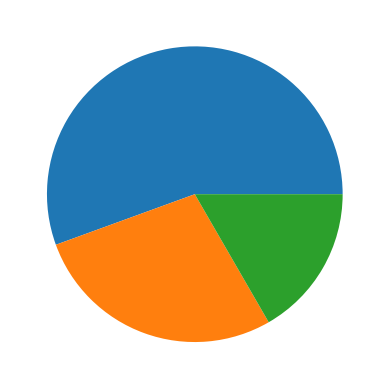

In [50]:
plt.pie([20,10,6])

<Axes: ylabel='hour'>

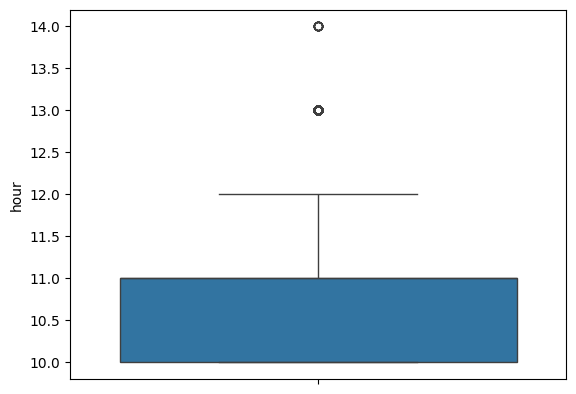

In [51]:
sns.boxplot(train['hour'])